In [1]:
import pandas as pd
import os
import os.path as path
import json
from pprint import pprint
from collections import Counter
import ast
import numpy as np
from string import punctuation
import string
import re
import swifter
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale = 2)

import matplotlib.pyplot as plt

def safe_div(x,y):
    if y == 0:
        return 0
    return x / y


def is_empty(x):
    if len(x)==0:
        return 0
    else:
        return 1
    

def get_match_score(row):
    return row['match_percentage']


def get_terms_matched(row):
    return row['bias_precense']


def is_word_in_text(word, text):
    pattern = r'\b{}\b'.format(word)        
    pattern = re.compile(pattern, re.MULTILINE)
    matches = re.search(pattern, text)
    return bool(matches)

def matched_words(path_lexicon, doc): 
    res = []
    with open(path_lexicon) as f:
        s1 = [line.rstrip("\n") for line in f.readlines()]

    l_s1, l_doc = s1, doc
    for ss1 in l_s1:
        if is_word_in_text(ss1, doc):
            res.append(ss1)           
    return {'matched_lexicon_words':res, 'num_matched_words':len(res), 'bias_precense': is_empty(res)}


root = path.abspath(path.join(os.getcwd(),"../.."))

df = pd.read_csv(root+'/data/raw/Webis-argument-framing.csv')
df['argument'] = df[['premise', 'conclusion']].agg('\n'.join, axis=1).str.lower()
#df = df[['premise', 'conclusion']]
df = df[['argument_id', 'frame_id', 'frame', 'topic_id', 'topic', 'argument','stance']]
df

,argument_id,frame_id,frame,topic_id,topic,argument,stance
0,0,0,economics,0,$700 billion US economic bailout,u.s. treasury secretary henry paulson summariz...,Pro
1,1,0,economics,0,$700 billion US economic bailout,"""job security: safeguarding jobs across the e...",Pro
2,2,0,economics,0,$700 billion US economic bailout,treasury secretary henry paulson summarized th...,Pro
3,3,0,economics,0,$700 billion US economic bailout,"""paulson plan provides a plan just as optimis...",Pro
4,4,0,economics,0,$700 billion US economic bailout,"""the treasury proposal to rescue the financia...",Pro
...,...,...,...,...,...,...,...
12321,14110,1622,endangered,1823,Zoos,while some argue that zoos are a means to prot...,Pro
12322,14111,1622,endangered,1823,Zoos,according to the world conservation union whic...,Pro
12323,14112,1622,endangered,1823,Zoos,zoos are a good place to house endangered spec...,Con
12324,14113,1622,endangered,1823,Zoos,if natural or human factors have made a specie...,Con


## Report verbs

Terms that express the process and reliability of claims to support authors’ writing. Terms such as alert, caution, asrgue [4].

In [2]:
report_verbs = root+'/data/external/bias_related_lexicons/report_verbs.txt'

df['bias_info_report_verbs'] = df['argument'].apply(lambda x: matched_words(report_verbs, x))
df['report_verbs']=df['bias_info_report_verbs'].apply(get_terms_matched)
#df = df.drop('bias_info', 1)

## Implicatives

Complement-taking verbs which come along with certain inferences regarding the status of their infinitival complements [2]. For example manage, dare:

> John **managed** to open the door

> John opened the door

In [3]:
implicatives = root+'/data/external/bias_related_lexicons/implicatives.txt'


df['bias_info_implicatives'] = df['argument'].apply(lambda x: matched_words(implicatives, x))
df['implicatives']=df['bias_info_implicatives'].apply(get_terms_matched)
#df = df.drop('bias_info', 1)


## Hedges

Terms  to  reduce  one’s  commitment  to  the  truth  of  a  proposition,  thus avoiding any bold prediction [1]. For example:

> The lower cost of living in more rural areas means a **possibly** higher standard of living.



In [4]:

hedges = root+'/data/external/bias_related_lexicons/hedges.txt'


df['bias_info_hedges'] = df['argument'].apply(lambda x: matched_words(hedges, x))
df['hedges']=df['bias_info_hedges'].apply(get_terms_matched)
#df = df.drop('bias_info', 1)


## Factives

Terms that presuppose the truth of their complement clause. Terms such as: `realize`, `discover`, `suffice`, `make sense`. For example from [1]:

> He **realized** that the oppression of black people was more of a result of economic exploitation than anything innately racist.

`Realize` and presuppose the truth of “the oppression of black people”

In [5]:

factives = root+'/data/external/bias_related_lexicons/factives.txt'



df['bias_info_factives'] = df['argument'].apply(lambda x: matched_words(factives, x))
df['factives']=df['bias_info_factives'].apply(get_terms_matched)
#df = df.drop('bias_info', 1)

## Assertives

Terms whose complement clauses assert a proposition. For example, `say`, `states` and `affirm` [1]. 

> The “no Boeing” theory is a controversial issue, even among conspiracists, many of whom have **pointed out** that it is disproved by...


In [6]:
assertives = root+'/data/external/bias_related_lexicons/assertives.txt'

df['bias_info_assertives'] = df['argument'].apply(lambda x: matched_words(assertives, x))
df['assertives']=df['bias_info_assertives'].apply(get_terms_matched)
#df = df.drop('bias_info', 1)

## Hube & Fetahu

The lexicon was created by using word vectors from words are expected to have a high density of bias words (Conservapedia). Given a small set of seed words that are associated with a strong political ideology between left and right in the US (e.g. media, immigrants, abortion). For each word they manually go through the list of closest words in their word representation and extract words that seem to convey a strong opinion [3]. For example: the closest words to `media` are `arrogance`, `blatant`, `despises`.

In [7]:
hube_and_fetahu = root+'/data/external/bias_related_lexicons/hube_fetahu_dict.txt'

df['bias_info_hube_fetahu'] = df['argument'].swifter.apply(lambda x: matched_words(hube_and_fetahu, x))
df['hube_and_fetahu']=df['bias_info_hube_fetahu'].apply(get_terms_matched)
#df = df.drop('bias_info', 1)

In [10]:
final = df[['topic','argument','report_verbs','bias_info_report_verbs', 
            'implicatives', 'bias_info_implicatives', 
            'assertives', 'bias_info_assertives', 
            'factives','bias_info_factives', 
            'hedges', 'bias_info_hedges', 'hube_and_fetahu', 'bias_info_hube_fetahu']]


final.to_csv(root+'/data/processed/waf_bias_related_lexicons_matching.csv', index=False, sep=',')

final

,topic,argument,report_verbs,bias_info_report_verbs,implicatives,bias_info_implicatives,assertives,bias_info_assertives,factives,bias_info_factives,hedges,bias_info_hedges,hube_and_fetahu,bias_info_hube_fetahu
0,$700 billion US economic bailout,u.s. treasury secretary henry paulson summariz...,1,"{'matched_lexicon_words': ['threaten'], 'num_m...",1,"{'matched_lexicon_words': ['avoid'], 'num_matc...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['threaten'], 'num_m..."
1,$700 billion US economic bailout,"""job security: safeguarding jobs across the e...",1,"{'matched_lexicon_words': ['threaten'], 'num_m...",1,"{'matched_lexicon_words': ['avoid'], 'num_matc...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['threaten'], 'num_m..."
2,$700 billion US economic bailout,treasury secretary henry paulson summarized th...,0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['generally'], 'num_...",1,"{'matched_lexicon_words': ['troubled'], 'num_m..."
3,$700 billion US economic bailout,"""paulson plan provides a plan just as optimis...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['can'], 'num_matche...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['uncertain'], 'num_...",1,"{'matched_lexicon_words': ['just', 'optimism',..."
4,$700 billion US economic bailout,"""the treasury proposal to rescue the financia...",1,"{'matched_lexicon_words': ['say', 'support', '...",1,"{'matched_lexicon_words': ['sense'], 'num_matc...",1,"{'matched_lexicon_words': ['think', 'say'], 'n...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['about'], 'num_matc...",1,"{'matched_lexicon_words': ['attuned', 'cynical..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12321,Zoos,while some argue that zoos are a means to prot...,1,"{'matched_lexicon_words': ['argue', 'see'], 'n...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['argue'], 'num_matc...",1,"{'matched_lexicon_words': ['see'], 'num_matche...",1,"{'matched_lexicon_words': ['should', 'argue'],...",1,"{'matched_lexicon_words': ['actually', 'justif..."
12322,Zoos,according to the world conservation union whic...,1,"{'matched_lexicon_words': ['expect'], 'num_mat...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['expect'], 'num_mat...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['about', 'could'], ...",1,"{'matched_lexicon_words': ['keeps'], 'num_matc..."
12323,Zoos,zoos are a good place to house endangered spec...,0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['good'], 'num_match..."
12324,Zoos,if natural or human factors have made a specie...,0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['can'], 'num_matche...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",0,"{'matched_lexicon_words': [], 'num_matched_wor...",1,"{'matched_lexicon_words': ['would'], 'num_matc...",1,"{'matched_lexicon_words': ['certainly', 'threa..."


# What is the amount of bias-related lexicon's terms in each topic?

Given a topic, how many arguments contain at least one report verb from the lexicon


## Reporting Verbs


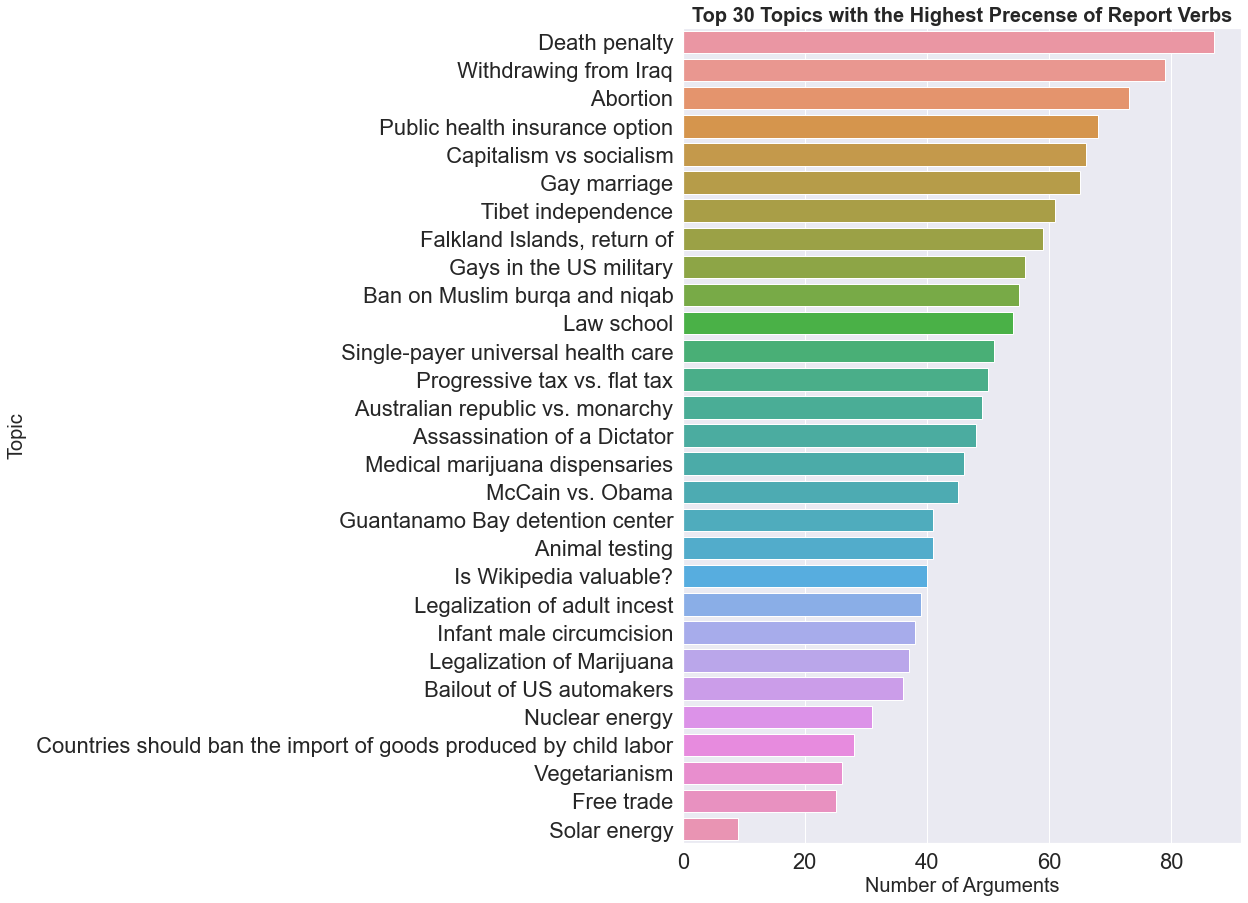

In [11]:
def plot_top30_more_biased_topics(final_df, bias_type):
    
    d = pd.crosstab([final_df[bias_type]], 
                    final_df["topic"], margins = True).T.sort_values(by='All', ascending=False, na_position='first').head(30)

    d = d[[1]].reset_index(inplace=False)
    d = d.rename({'topic':'topic', 1:'bias'}, axis=1)
    d = d.drop([0])
    d = d.reset_index(drop=True).rename_axis(None, axis=1).sort_values('bias', 
                                                                       ascending=False).reset_index(drop=True)

    d.to_csv('{}_topic_precense.csv'.format(bias_type), index=False, sep=',')

    # plot figure
    plt.figure(figsize=(10, 15))
    ax = sns.barplot(x='bias', y='topic', data=d,  orient = 'h')
    ax.set_xlabel('Number of Arguments', fontsize=20)
    ax.set_ylabel('Topic', fontsize=20)

    
    ax.axes.set_title("Top 30 Topics with the Highest Precense of {}".format(string.capwords(bias_type.replace("_"," "))),weight='bold', ha='center',fontsize=20)

    # get label text
    _, ylabels = plt.yticks()
    _, xlabels = plt.xticks()
    plt.savefig(root+'/reports/visualizations/{}_topic_precense.png'.format(bias_type), bbox_inches = 'tight')

    plt.show()
    
    
plot_top30_more_biased_topics(final, 'report_verbs')    


## Implicatives

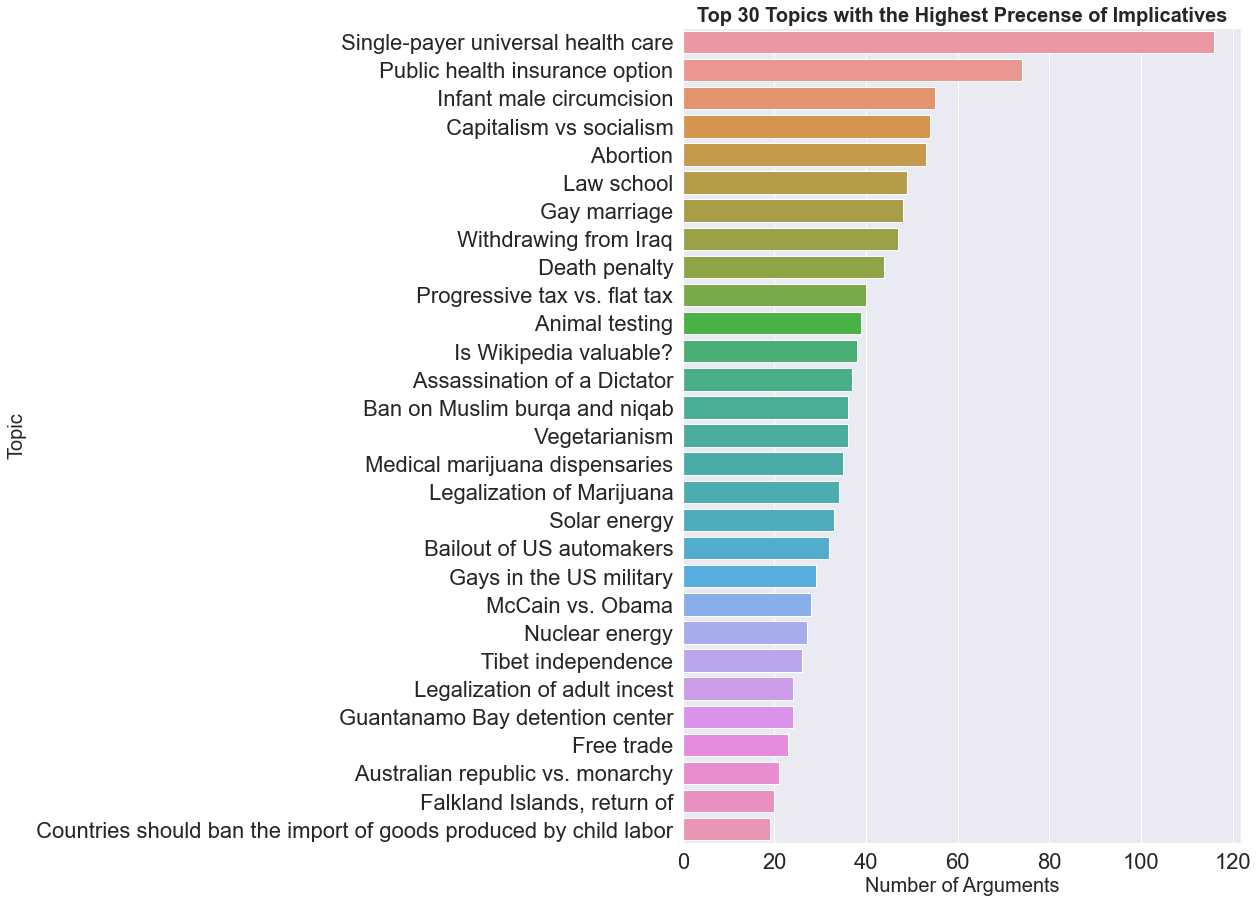

In [12]:

plot_top30_more_biased_topics(final, 'implicatives') 



## Hedges



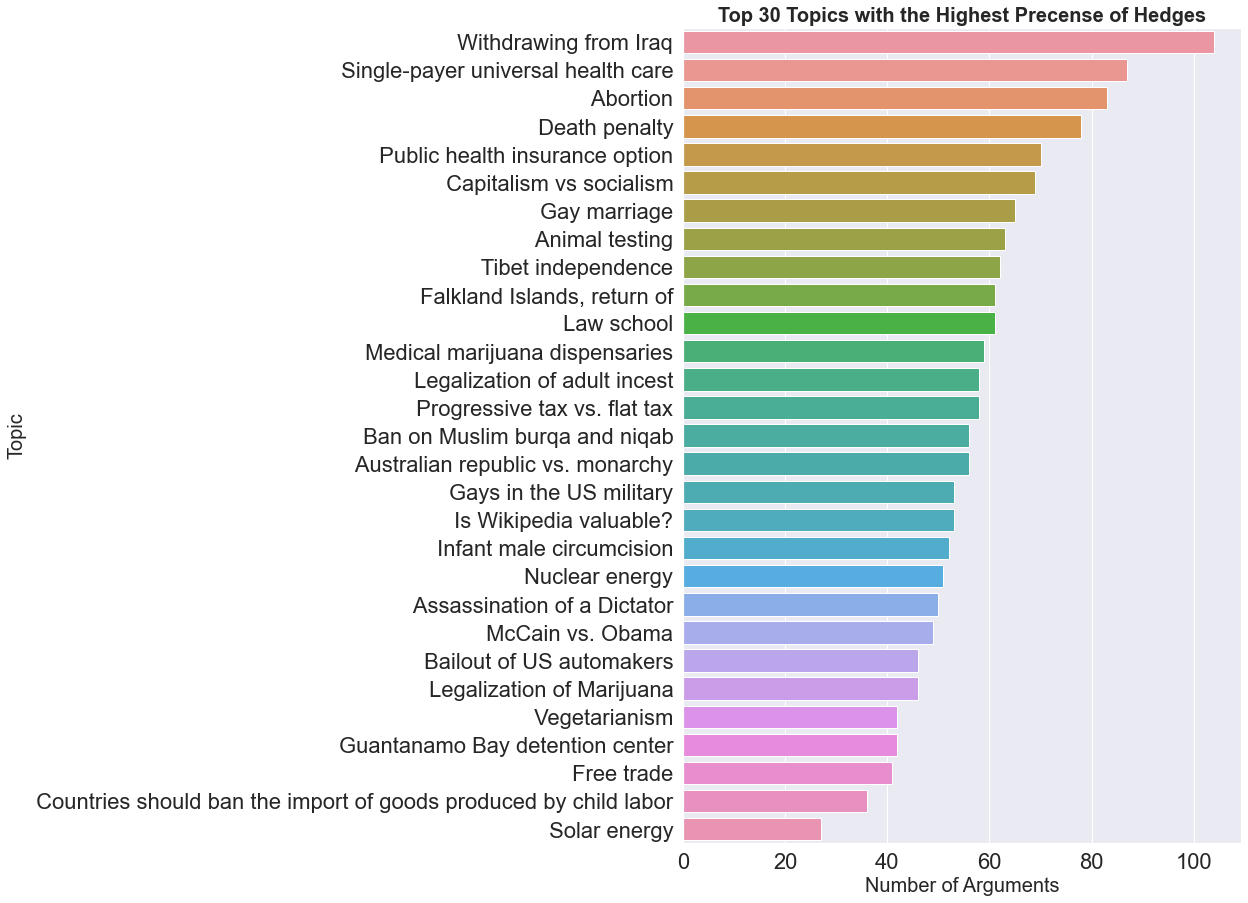

In [13]:
plot_top30_more_biased_topics(final, 'hedges')    


## Factives

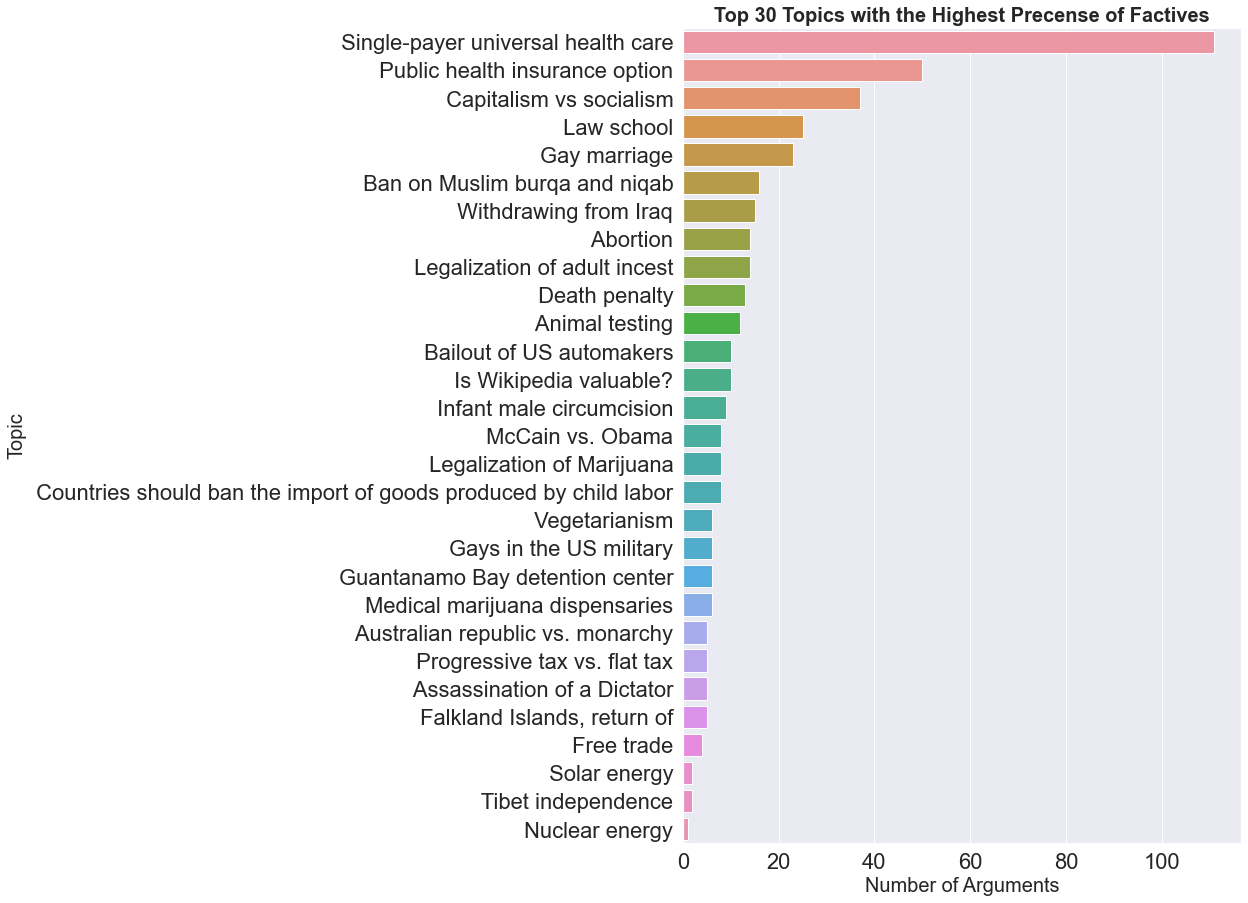

In [14]:
plot_top30_more_biased_topics(final, 'factives')    


## Assertives


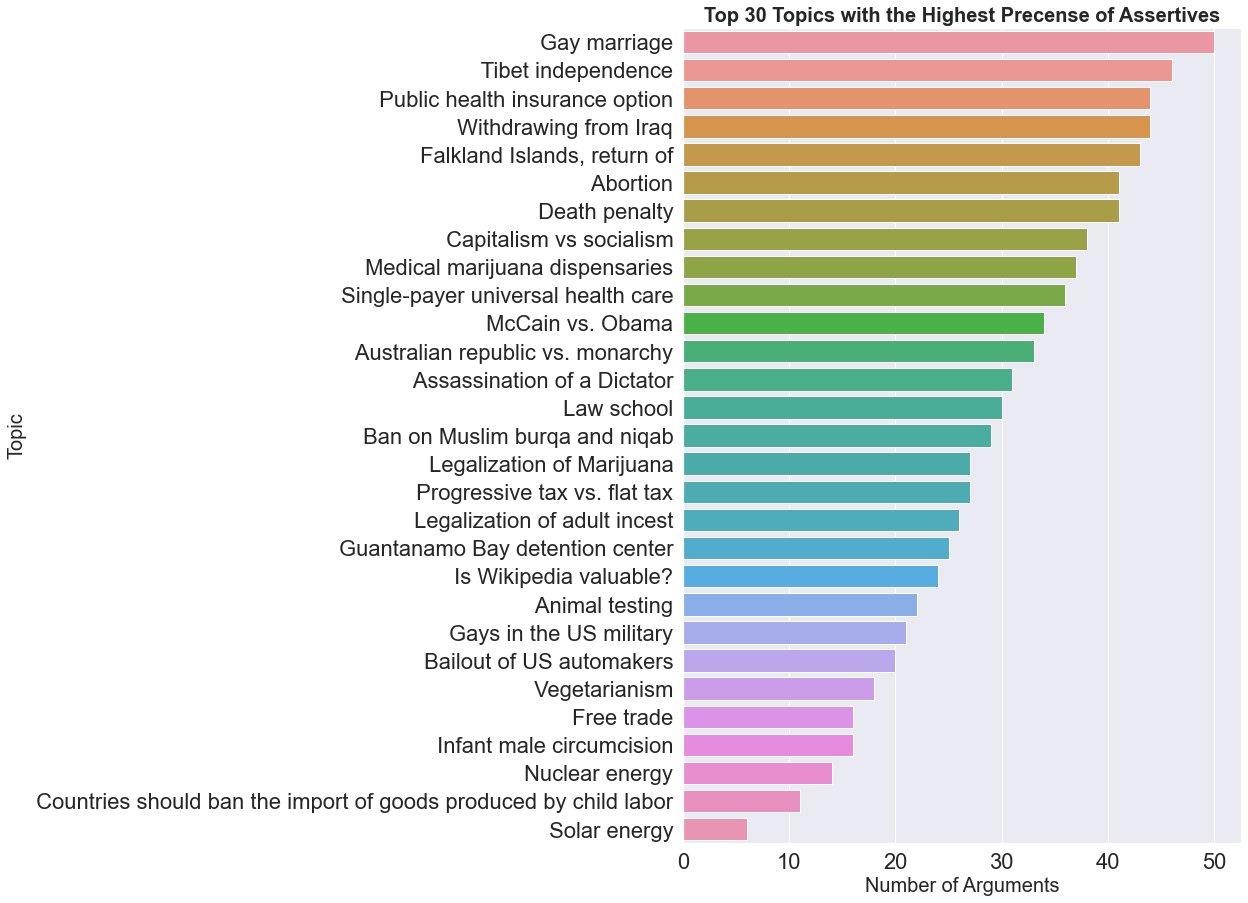

In [15]:
plot_top30_more_biased_topics(final, 'assertives')    



## Hube & Fetahu Lexicon

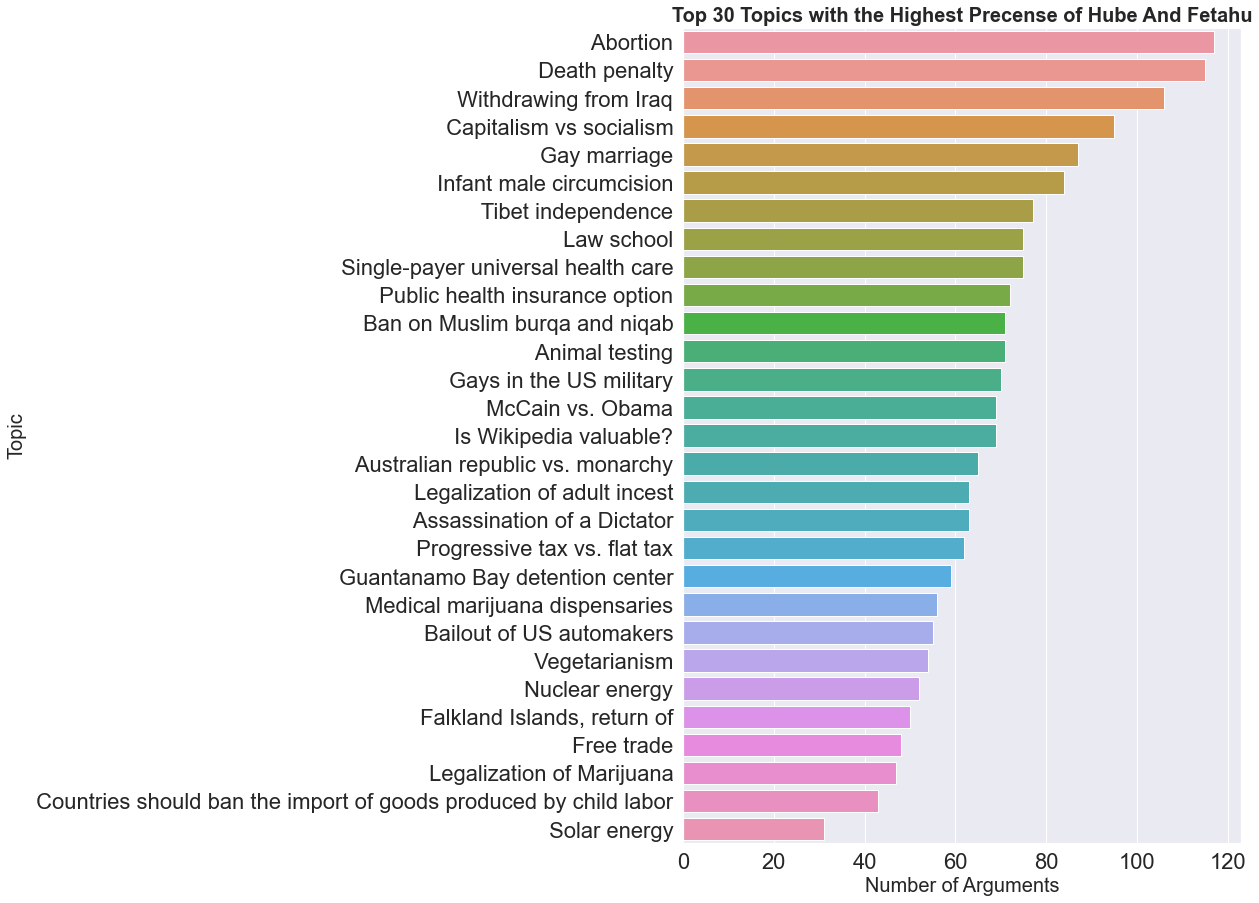

In [17]:
plot_top30_more_biased_topics(final, 'hube_and_fetahu')    



In [18]:
bias_counts = final[['report_verbs', 'implicatives', 'assertives', 'factives', 'hedges', 'hube_and_fetahu']]
bias_counts

,report_verbs,implicatives,assertives,factives,hedges,hube_and_fetahu
0,1,1,0,0,0,1
1,1,1,0,0,0,1
2,0,0,0,0,1,1
3,0,1,0,0,1,1
4,1,1,1,0,1,1
...,...,...,...,...,...,...
12321,1,0,1,1,1,1
12322,1,0,1,0,1,1
12323,0,0,0,0,0,1
12324,0,1,0,0,1,1


In [19]:
bias_counts.loc["Total"] = bias_counts.sum()

/Users/user/miniconda3/envs/differential-bias/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
sf= bias_counts.loc['Total']

bias_type_frec_arg = pd.DataFrame({'bias_type':sf.index, 'num_args':sf.values}).sort_values('num_args')

print(bias_type_frec_arg.index)
bias_type_frec_arg

Int64Index([3, 2, 1, 0, 4, 5], dtype='int64')


,bias_type,num_args
3,factives,1480
2,assertives,3759
1,implicatives,5290
0,report_verbs,6441
4,hedges,8191
5,hube_and_fetahu,9285


In [21]:
total = sum(bias_type_frec_arg['num_args'].tolist()[:-1])

bias_type_frec_arg = bias_type_frec_arg.append({'bias_type':'Total', 'num_args':total}, ignore_index=True)
# For removing fetahu and hube lexicon
bias_type_frec_arg=bias_type_frec_arg.drop(5, axis='index')

bias_type_frec_arg

,bias_type,num_args
0,factives,1480
1,assertives,3759
2,implicatives,5290
3,report_verbs,6441
4,hedges,8191
6,Total,25161


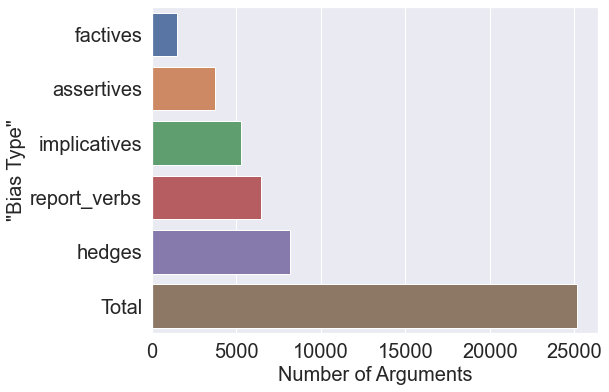

In [38]:
# plot figure
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='num_args', y='bias_type', data=bias_type_frec_arg,  orient = 'h')
ax.set_xlabel('Number of Arguments', fontsize=20)
ax.set_ylabel('"Bias Type"', fontsize=20)

    
#ax.axes.set_title("Types of Biases Across WAF dataset",weight='bold', ha='center',fontsize=20)

# get label text
_, ylabels = plt.yticks(fontsize=20)
_, xlabels = plt.xticks(fontsize=20)
plt.savefig(root+'/reports/visualizations/{}_bias_arg_freq.png', bbox_inches = 'tight')

plt.show()

# Validations

## Factive manual validation


In [23]:
final.iloc[[463]]

,topic,argument,report_verbs,bias_info_report_verbs,implicatives,bias_info_implicatives,assertives,bias_info_assertives,factives,bias_info_factives,hedges,bias_info_hedges,hube_and_fetahu,bias_info_hube_fetahu
463,Adult male circumcision,"""i am very happy for my son that he is natura...",1,"{'matched_lexicon_words': ['think'], 'num_matc...",1,"{'matched_lexicon_words': ['sense', 'can'], 'n...",1,"{'matched_lexicon_words': ['think'], 'num_matc...",1,"{'matched_lexicon_words': ['know', 'make sense...",1,"{'matched_lexicon_words': ['about', 'should'],...",1,"{'matched_lexicon_words': ['dangerous', 'enjoy..."


In [24]:
#make sense
final.iloc[[463]]['bias_info_factives'].tolist()

[{'matched_lexicon_words': ['know', 'make sense'],
  'num_matched_words': 2,
  'bias_precense': 1}]

## hedges manual validation

In [25]:
print(final['argument'][2697])
final.iloc[[2697]]['bias_info_hedges'].tolist()

thomas nash, international coordinator for the cluster munition coalition, a network of about 200 organizations promoting the ban. - "from our perspective, this is quite an amazing result. only a year and a half ago, countries would have said you were mad to think the world could turn around and ban cluster munitions with an international treaty, but what we’ve achieved here in dublin is exactly that."
international will for ban demonstrates success is possible


[{'matched_lexicon_words': ['about',
   'around',
   'could',
   'from our perspective',
   'possible',
   'would',
   'quite'],
  'num_matched_words': 7,
  'bias_precense': 1}]

## implicatives manual validation

In [26]:
final.iloc[[41]]['bias_info_implicatives'].tolist()

[{'matched_lexicon_words': ['allow'],
  'num_matched_words': 1,
  'bias_precense': 1}]

# References

[1] https://www.aclweb.org/anthology/P13-1162.pdf

[2] https://pnadathur.github.io/pdfs/implicatives_final.pdf

[3] http://l3s.de/~fetahu/publications/wiki_workshop_bias.pdf

[4] https://www.researchgate.net/publication/340281615_A_Corpus-Based_Study_on_the_Use_of_Reporting_Verbs_in_Applied_Linguistics_Articles
